### Preprocessing Pipeline
1. Create a BIDSDataGrabber Node to read data files
2. Create a IdentityInterface Node to iterate over multiple Subjects
3. Create following Nodes for preprocessing: (Based on [Nan-kuei Chen's resting state analysis pipeline:](https://wiki.biac.duke.edu/biac:analysis:resting_pipeline)
    - [-] convert data to nii in LAS orientation (Skip if NYU is already in [LAS Orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm))
    - [x] Exclude 4 volumes from the functional scan 
    - [x] slice time correction
    - [x] motion correction, {[then regress out motion parameter] - This will be done later}
    - [x] Skull stripping and mask generation using mean of functional scan got using mcflirt
    - [x] Apply mask to Functional image
    - [x] Co-Registration with Anatomical Image
    - [x] normalize functional data
    - [-] regress out WM/CSF - Not doing coz of the debate that WM also has some activations
    - [x] bandpass filter
    
4. Embed them into a workflow
5. Do the Preprocessing of 4 subjects

In [1]:
from bids.grabbids import BIDSLayout
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold,Info)
from nipype.interfaces.afni import Resample
from nipype.interfaces.io import DataSink
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
import os
from os.path import join as opj
from nipype.interfaces import afni
import nibabel as nib

## Define Paths
Let's set the directory names:
1. **base_directory** : The directory where all the output of my program will be saved
2. I have created 2 workflows, one onside another:
    3. **parent_wf_directory**: The name of the folder where the top level workflow's output is saved 
    4. **child_wf_directory**: The name of the folder where the Second level workfolw's output is saved 
5. **data_directory**: Directory where the BIDS data is stored.
        

In [2]:
# Paths

path_cwd = os.getcwd()
path_split_list = path_cwd.split('/')
s = path_split_list[0:-1]
s = opj('/',*s) # *s converts list to path, # very important to add '/' in the begining so it is read as directory later
base_directory = opj(s,'result') 
parent_wf_directory = 'preprocessPipeline'
child_wf_directory = 'coregistrationPipeline'

data_directory = opj(s,"data/ABIDE-BIDS/NYU/")

# mask_file = '/media/varun/LENOVO4/Projects/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/skullStrip/sub-0050952_T1w_resample_brain_mask.nii.gz'
# os.chdir(path)

In [3]:
base_directory # result folder

'/home/jovyan/work/preprocess/result'

In [4]:
number_of_subjects = 4 # Number of subjects you wish to preprocess


In [5]:
layout = BIDSLayout(data_directory)

Checking the Data directory Structure

In [6]:
# !tree /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/

In [7]:
layout.get_subjects(); # working!Gives us list of all the subjects

To get the metadata associated with a subject. [Takes as argumment the filename of subject ]

In [8]:
path_subject = opj(data_directory,'sub-0050954/func/sub-0050952_task-rest_run-1_bold.nii.gz')
metadata = layout.get_metadata(path=path_subject)

Let's extract the Repetition Time (of fMRI) of the subject whose metadata was extracted above

In [9]:
TR  = metadata['RepetitionTime']
metadata; # just add or remove the semicolon to supress or see the output

Lets look at a better way to extract the TR of an experiment of fMRI.  
In BIDS format there is one json file associated with the data set that contains the details of the data acquisition. Here we have -> ```task-rest_bold.json```. Let's extract the TR from this file.  
Similarly there is a json file associated with the anatomical scan as well. Here - ```T1w.json```

In [10]:
import json
json_path = opj(data_directory,'task-rest_bold.json')
with open(json_path, 'rt') as fp:
    task_info = json.load(fp)
    
# task_info now saves all the key-value pairs extracted from json
# 'rt' means that you want to open the file in read mode and text mode(not sure what text mode is) 
# Also -> with open() as ... is just a fancy way of reading file that makes sure that the file object
# is destroyed automatically

Now you can extract the TR

In [11]:
TR = task_info['RepetitionTime']

Create a list of subjects

In [12]:
subject_list = (layout.get_subjects())[0:number_of_subjects]

Create our own custom function - BIDSDataGrabber using a Function Interface.

In [13]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]
    func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return anat_file_path[0],func_file_path[0]

# Refer to Supplementary material section One for info on arguments for layout.get()

Wrap it inside a Node

In [14]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names=['anat_file_path','func_file_path']), name='BIDSDataGrabber')
BIDSDataGrabber.iterables = [('subject_id',subject_list)]
BIDSDataGrabber.inputs.data_dir = data_directory

In [15]:
# To test the function wrapped in the node

# BIDSDataGrabber.inputs.data_dir = data_directory
# BIDSDataGrabber.inputs.subject_id = layout.get_subjects()[0] # gives the first subject's ID
# res = BIDSDataGrabber.run()

# res.outputs


### Skipping 4 starting scans
Extract ROI for skipping first 4 scans of the functional data 
> **Arguments:**  
t_min: (corresponds to time dimension) Denotes the starting time of the inclusion  
t_size: Denotes the number of scans to include

The logic behind skipping 4 initial scans is to take scans after the subject has stabalized in the scanner.

In [16]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

### Slice time correction
Created a Node that does slice time correction
> **Arguments**:  
index_dir=False -> Slices were taken bottom to top i.e. in ascending order  
interleaved=True means odd slices were acquired first and then even slices [or vice versa(Not sure)] 

In [17]:
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

In [18]:
# To test Slicetimer

# subject_id = layout.get_subjects()[0] # gives the first subject's ID
# func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])] 
# slicetimer.inputs.in_file = func_file_path[0]
# res = slicetimer.run()
# res.outputs

### Motion Correction
Motion correction is done using fsl's mcflirt. It alligns all the volumes of a functional scan to each other

In [19]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

In [20]:
# To test mcflirt

# subject_id = layout.get_subjects()[0] # gives the first subject's ID
# func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])] 
# mcflirt.inputs.in_file = func_file_path[0]
# res_mcflirt = mcflirt.run()
# res_mcflirt.outputs

### Skull striping
I used fsl's BET

In [21]:
skullStrip = Node(BET(mask=True),name='skullStrip') 

*Note*: Do not include special characters in ```name``` field above coz then  wf.writegraph will cause issues

In [22]:
# BET.help(); # Useful to see what are the parameters taken by BET

### Apply Mask to functional data
Mean file of the motion corrected functional scan is sent to skullStrip to get just the brain and the mask_image. Mask_image is just a binary file (containing 1 where brain is present and 0 where it isn't).    
After getting the mask_image form skullStrip, apply that mask to aligned functional image to extract its brain and remove the skull

In [23]:
# Function
# in_file: The file on which you want to apply mask
# mask_file:  The mask you want to use. Make sure that mask_file has same size as in_file
# out_file : Result of applying mask in in_file -> Gives the path of the output file

def applyMask_func(in_file, mask_file):
    import numpy as np
    import nibabel as nib
    import os
    from os.path import join as opj

    # convert from unicode to string : u'/tmp/tmp8daO2Q/..' -> '/tmp/tmp8daO2Q/..' i.e. removes the prefix 'u'
    mask_file = str(mask_file)

    brain_data = nib.load(in_file)
    mask_data = nib.load(mask_file)

    brain = brain_data.get_data()
    mask = mask_data.get_data()
    
    # applying mask by multiplying elementwise to the binary mask

    if len(brain.shape) == 3: # Anat file
        brain = np.multiply(brain,mask)
    elif len(brain.shape) > 3: # Functional File
        for t in range(brain.shape[-1]):
            brain[:,:,:,t] = np.multiply(brain[:,:,:,t],mask)
    else:
        pass

    # Saving the brain file
    
    path = os.getcwd()
    

    in_file_split_list = in_file.split('/')
    in_file_name = in_file_split_list[-1]

    out_file = in_file_name + '_brain.nii.gz' # changing name
    brain_with_header = nib.Nifti1Image(brain, affine=brain_data.affine,header = brain_data.header)
    nib.save(brain_with_header,out_file)
    
    out_file = opj(path,out_file)
    
    return out_file



#### Things learnt:
1. I found out that whenever a node is being executed, it becomes the current directory and whatever file you create now, will be stored here.
2. #from IPython.core.debugger import Tracer; Tracer()()    # Debugger doesnt work in nipype

Wrap the above function inside a Node

In [24]:
applyMask = Node(Function(function=applyMask_func, input_names=['in_file','mask_file'],
                                output_names=['out_file']), name='applyMask')

## Resample
I needed to resample the anatomical file from 1mm to 2mm. Because registering a 1mm file was taking a huge amount of time.  


In [25]:
# Resample - resample anatomy to 2x2x2 voxel resolution
resample = Node(Resample(voxel_size=(2, 2, 2), resample_mode='Cu', # cubic interpolation
                         outputtype='NIFTI'),
                name="resample")

In [26]:
# Resample.help() # To understand what all parameters Resample supports 

In [27]:
# resample.outputs

## Datasink
I needed to define the structure of what files are saved and where.

In [28]:
# Create DataSink object
dataSink = Node(DataSink(), name='datasink')

# Name of the output folder
dataSink.inputs.base_directory = opj(base_directory,'datasink')




To create the substitutions I looked the `datasink` folder where I was redirecting the output. I manually selected the part of file/folder name that I wanted to change and copied below to be substituted.  

**TODO:** Using datasink create a hierarchical directory structure i.e. folder in folder - to exactly match BIDS.

In [29]:
# Define substitution strings so that the data is similar to BIDS
substitutions = [('_subject_id_', 'sub-'),
                 ('_resample_brain_flirt.nii_brain', ''),
                 ('_roi_st_mcf_flirt.nii_brain_flirt', ''),
                ]

# Feed the substitution strings to the DataSink node
dataSink.inputs.substitutions = substitutions

### Some nodes needed for Co-registration and Normalization

I observed using fslsyes that the brain is enlarged if you Normalize a  brain resampled to 2mm brain. This in turn causes the functional data to enlarge as well after normalization. So, I will apply MNI152_2mm brain mask to the  resample brain after it has been normalized.

For that let's first create a Node - `coreg_step1_Normalize_masking`  that applies the  MNI152_2mm brain mask to the Output of Coreg_step1_Normalize. 

In [30]:
# FLIRT.help()

In [31]:
# Node for getting the xformation matrix 
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")

# Node for applying xformation matrix to functional data
coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")


# Node for Normalizing/Standardizing the anatomical and getting the xformation matrix
coreg_step1_Normalize = Node(FLIRT(output_type='NIFTI'), name="coreg_step1_Normalize")

# Extra masking of 2mm anat file based on MNI mask coz it was a bit dialated
coreg_step1_Normalize_masking = Node(Function(function=applyMask_func, input_names=['in_file','mask_file'],
                                output_names=['out_file']), name="coreg_step1_Normalize_masking")


#Node for applying the xformation matirix to functional data

coreg_step2_Normalize = Node(FLIRT(output_type='NIFTI', apply_xfm=True), name="coreg_step2_Normalize")


# Extra masking of 2mm func file based on MNI mask coz it was a bit dialated
coreg_step2_Normalize_masking = Node(Function(function=applyMask_func, input_names=['in_file','mask_file'],
                                output_names=['out_file']), name="coreg_step2_Normalize_masking")

/opt/conda/envs/python2/lib/python2.7/site-packages/nipype-0.13.0rc1-py2.7.egg/nipype/interfaces/base.py:431: UserWarning: Input apply_xfm requires inputs: in_matrix_file
  warn(msg)


I wanted to use the MNI file as input to the workflow so I created an Identity Node that reads the MNI file path and outputs the same MNI file path. Then I connected this node to whereever it was needed.

In [32]:
MNI152_2mm = Node(IdentityInterface(fields=['standard_file','mask_file']),
                  name="MNI152_2mm")
# Set the mask_file and standard_file input in the Node. This setting sets the input mask_file permanently.
MNI152_2mm.inputs.mask_file = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
MNI152_2mm.inputs.standard_file = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [33]:
# Testing

# res = MNI152_2mm_mask.run()
# res.outputs

In [34]:
# afni.Bandpass.help()

## Band Pass Filtering
Let's do a band pass filtering on the data using the code from https://neurostars.org/t/bandpass-filtering-different-outputs-from-fsl-and-nipype-custom-function/824/2

In [35]:
### AFNI

bandpass = Node(afni.Bandpass(highpass=0.008, lowpass=0.08, 
                         despike=False, no_detrend=True, notrans=True, 
                         tr=2.0,outputtype='NIFTI_GZ'),name='bandpass')

bandpass.inputs.mask = MNI152_2mm.outputs.mask_file

In [36]:
# Testing bandpass on the func data in subject's space

# First comment out the bandpass.inputs.mask as it is in standard space.

# subject_id = layout.get_subjects()[0] # gives the first subject's ID
# func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])] 
# bandpass.inputs.in_file = func_file_path[0]
# res = bandpass.run();

In [37]:
# To view in fsl I need to save this file. You can change the the location as per your need.
# First run utility functions section. It contains the load_and_save function
# load_and_save(res.outputs.out_file,'/home/jovyan/work/preprocess/result/filtered_func.nii') 

In [38]:
# afni.Bandpass.help() # to see what all parameters are supported by Bandpass filter of afni

## AFNI's filter is working good:
### Next:
- [x] Add the mask as parameter to the afni Node
- [] Add the Node to the workflow
- [x] Improve the data sink
- [] Create Voxel pair FC map

## Co-Registration, Normalization and Bandpass Workflow
1. Co-registration means alligning the func to anat
2. Normalization means aligning func/anat to standard
3. Applied band pass filtering in range - highpass=0.008, lowpass=0.08

In [39]:
wf_coreg = Workflow(name="coregistrationPipeline")
wf_coreg.base_dir = "/home/jovyan/work/preprocess/result" 
# Dir where all the outputs will be stored(inside coregistrationPipeline folder).


wf_coreg.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]), # Sent the mean volume from mcflirt to coreg_step1
                  
            (BIDSDataGrabber,resample,[('anat_file_path','in_file')]), # Resampled the anat file to 2mm
                  
            (resample,coreg_step1,[('out_file','reference')]), # Make the resampled file as reference in coreg_step1
            
            # Sec 1. The above 3 steps registers the mean image to resampled anat image and 
            # calculates the xformation matrix       
                  
                  
                  
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), # Motion corrected volumes (wrt mean-volume) given ...
            # ...as input to coreg_step2
                  
            (resample,coreg_step2,[('out_file','reference')]), # Resampled 2mm anat used as reference to coreg_step2
                  
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),# xformation matrix (mean->anat) ...
            # ... is used to transform func volumes to resampled anat
            
            # Sec 2. The above 3 steps uses the xformation matrix computed in Sec 1. and
            # trasforms the func volumes to resampled anat.        
          
                  
                                  
            (resample, skullStrip, [('out_file','in_file')]), # resampled anat image is skull stripped and mask ...
            # ... is generated
                  
            (skullStrip, applyMask, [('mask_file','mask_file')]), # the mask is inputted in applyMask
                  
            (coreg_step2, applyMask, [('out_file','in_file')]), # The functional image is inputted in applyMask
                  
            # Sec. 3. The above 3 Steps result is the skull stripping of func data based on mask got from anat
                  
                  
            (MNI152_2mm, coreg_step1_Normalize, [(('standard_file','reference'))]),     
            (skullStrip, coreg_step1_Normalize, [('out_file','in_file')]), # gives the transformation matrix ...
            #... anat->MNI_2mm
            
            (coreg_step1_Normalize, coreg_step1_Normalize_masking, [('out_file','in_file')]), # masking again the ...
            # ... Normalized anat image
                  
            (MNI152_2mm, coreg_step1_Normalize_masking, [('mask_file','mask_file')]), # using the mask from ...
            # ... MNI152_2mm_mask 
            
            # Sec 4. Above 3 steps masks again the normalized anat and the next statement saves it to dataSink
                  
                  
            
            # Saving the normalized anatomical file of a subject
            (coreg_step1_Normalize_masking,dataSink,[('out_file','preprocessed.@normalized_anat')]),
                  
#------------------------------------------------------------------------------------------------------------------                 
#             # TODO: Now register the functional mean image to the above got normalized anat using coreg_step1
#                   # - Need to first create a xformation matrix with:
#                   #     - Reference as normalized anat got from - coreg_step1_Normalize_masking
#                   #     - in_file = func volume got from - applyMask
#                   #     - 
#             (coreg_step1_Normalize_masking, coreg_step1, [('out_file','reference')]),
#             (mcflirt->skullStrip, coreg_step1, [('out_file','in_file')]),    
#-------------------------------------------------------------------------------------------------------------------  
                  
                  
            (MNI152_2mm, coreg_step2_Normalize, [(('standard_file','reference'))]),           
                                
            (applyMask, coreg_step2_Normalize, [('out_file','in_file')] ), # Applies the transform to the ...
            # ... functional file       
                  
            # Now, apply the matrix got using coreg_step1 to the functional  
                  
            (coreg_step1_Normalize, coreg_step2_Normalize, [('out_matrix_file','in_matrix_file')]),
            
            # Sec 5. The above steps transforms the functional to the MNI space using the xformation matrix (resampled_anat -> MNI)      
      
                  
                  
            # Apply extra masking of MNI_2mm to Normalized functional file coz it is a bit dialated       
            
            (MNI152_2mm, coreg_step2_Normalize_masking, [('mask_file','mask_file')]), # using the mask from ...
            # ... MNI152_2mm_mask       
                  
            (coreg_step2_Normalize, coreg_step2_Normalize_masking, [('out_file','in_file')]), # Outputs the ...
            # ... normalized and masked functional file of a subject
                  
            (coreg_step2_Normalize_masking, bandpass, [('out_file','in_file')]), # Perform band pass filtering
                  
            (bandpass, dataSink, [('out_file','preprocessed.@filtered_func')]) # saving the normalized and filtered ...
            # ... functional file of a subject     
           
                       
            ])



## Observation:
Applying masking again on the Normalized func file greately reduced the size from ~600MB -> ~150MB. I think Normalizing might have generated some extra voxels in the region of 'no brain'. Masking again got rid of them. Hence, reduced size.

## Main Workflow

In [40]:
# Create the workflow
# Refer to Supplementary material's Section Two. for more on workspaces

wf = Workflow(name="preprocessPipeline")
base_dir = opj(s,'result')
wf.base_dir = base_dir # Dir where all the outputs will be stored(inside BETFlow folder).

wf.connect([      (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,wf_coreg,[('slice_time_corrected_file','mcflirt.in_file')]),
           ])
# Run it in parallel
%time wf.run('MultiProc', plugin_args={'n_procs': 8})

171004-11:52:57,638 workflow INFO:
	 Workflow preprocessPipeline settings: ['check', 'execution', 'logging']
171004-11:52:57,813 workflow INFO:
	 Running in parallel.
171004-11:52:57,827 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a3 ID: 0
171004-11:52:57,872 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a3 jobid: 0
171004-11:52:57,901 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a1 ID: 2
171004-11:52:57,929 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a1 jobid: 2
171004-11:52:57,935 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a2 ID: 4
171004-11:52:57,976 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a2 jobid: 4
171004-11:52:57,978 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a0 ID: 13
171004-11:52:58,5 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a0 jobid: 13
171004-11:52:58,12 workflow INFO:
	 Executing: extract.a3 ID: 1
171004-11:52:58,108 workflow INFO:
	 [Job finished] jobname: extract.a3 jobid: 1
171004-11:52:58,

171004-11:53:00,350 workflow INFO:
	 [Job finished] jobname: coreg_step2_Normalize.a1 jobid: 50
171004-11:53:00,352 workflow INFO:
	 Executing: datasink.a3 ID: 56
171004-11:53:00,389 workflow INFO:
	 Executing: datasink.a2 ID: 59
171004-11:53:00,392 workflow INFO:
	 Executing node datasink.a3 in dir: /home/jovyan/work/preprocess/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050955/datasink
171004-11:53:00,481 workflow INFO:
	 Executing node datasink.a2 in dir: /home/jovyan/work/preprocess/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050954/datasink
171004-11:53:00,484 interface INFO:
	 sub: /home/jovyan/work/preprocess/result/datasink/preprocessed/_subject_id_0050955/sub-0050955_T1w_resample_brain_flirt.nii_brain.nii.gz -> /home/jovyan/work/preprocess/result/datasink/preprocessed/sub-0050955/sub-0050955_T1w.nii.gz
171004-11:53:00,486 interface INFO:
	 sub: /home/jovyan/work/preprocess/result/datasink/preprocessed/_subject_id_0050955/sub-0050955_task-res

### Summary:

171004-11:53:01,113 workflow INFO:
	 Creating detailed dot file: /home/jovyan/work/preprocess/result/preprocessPipeline/graph_detailed.dot
171004-11:53:05,373 workflow INFO:
	 Creating dot file: /home/jovyan/work/preprocess/result/preprocessPipeline/graph.dot


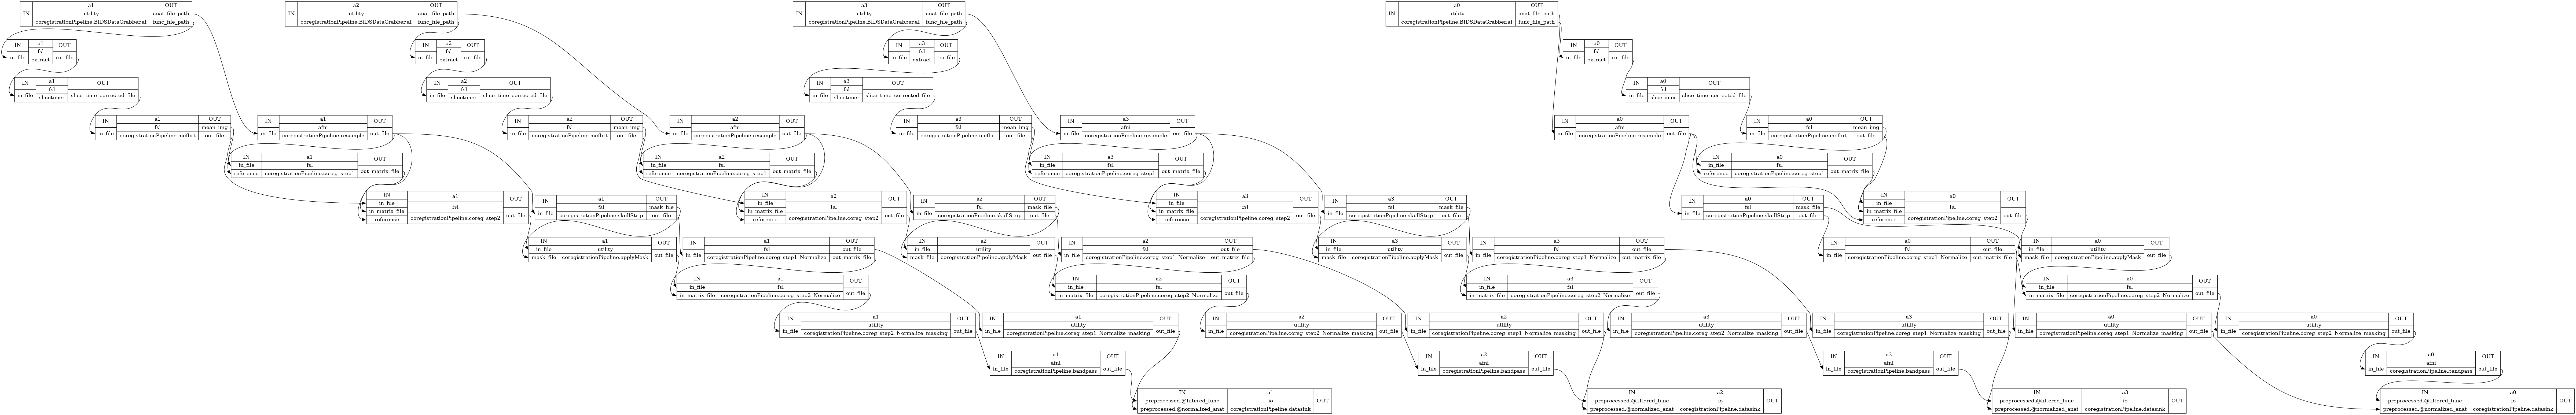

In [41]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)
file_name = opj(base_directory,'preprocessPipeline/graph_detailed.dot.png')
Image(filename=file_name)

### Summary [Incomplete]
```
wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,mcflirt,[('slice_time_corrected_file','in_file')]),
                  (mcflirt, skullStrip, [('mean_img', 'in_file')]),
                  (mcflirt,applyMask,[('out_file','brain_file')]),
                  (skullStrip, applyMask, [('mask_file', 'mask_file')]), 
                  ])
```

In the above created workflow the `infosource` node iterates over the `subject_id`, it creates a Node and for each Subject ID it sends `data_dir` (path where the data resides) and the subject specific `subject_id` to `BIDSDataGrabber` Node.

`BIDSDataGrabber` Node accepts the above 2 parameters, calls the function `get_nifti_filenames(subject_id,data_dir)`which returns the path of the anatomical and BOLD files of the subject with given subject_id and hence the Node produces output that I call `func_file_path` and `anat_file_path`. I have used only `func_file_path`right now.

The file path denoted by '``func_file_path``' is then fed as input to `extract` that removes 4 initial brain volumes of the functional scan.

Its output is called - `slice_time_corrected_file` which is fed to `mcflirt` node to correct the movion between volumes of an individual subject. This is called **Motion Correction**.

In next step the mean_image from `mcflirt` is sent to `skullStrip` to get the mask. The role of `skullStrip` is just to obtain mask from the mean EPI image.

The mask got above is then applied to the functional volume to get rif of skull.



The final results are stored in the directory : `/home/jovyan/work/preprocess/result/BETFlow`. Every node has its own folder where its results are stored.




## Functional Connectivity
1. Import the full brain atlas
2. cluster the voxel time seties of each of ROI's
3. Calculate the FC matrix

In [42]:
atlasPath = opj(s,'atlas/Full_brain_atlas_thr0-2mm/fullbrain_atlas_thr0-2mm.nii.gz')

In [43]:
atlasObject = nib.load(atlasPath)

In [44]:
atlas = atlasObject.get_data()

In [45]:
atlas.max()

274.0

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


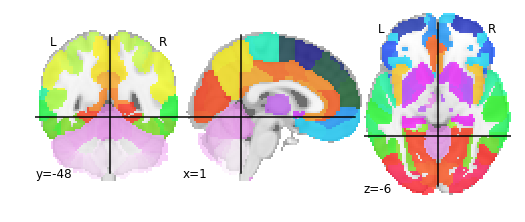

In [46]:
%matplotlib inline
from nilearn import plotting
plotting.plot_roi(atlasObject)


In [47]:
fmri_filenames = opj(dataSink.inputs.base_directory,'preprocessed/sub-0050952/sub-0050952_task-rest_run-1_bold.nii.gz')
fmri_filenames

'/home/jovyan/work/preprocess/result/datasink/preprocessed/sub-0050952/sub-0050952_task-rest_run-1_bold.nii.gz'

In [48]:
# Refrence: http://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#extract-signals-on-a-parcellation-defined-by-labels

from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlasPath, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. 
time_series = masker.fit_transform(fmri_filenames)

[NiftiLabelsMasker.fit_transform] loading data from /home/jovyan/work/preprocess/atlas/Full_brain_atlas_thr0-2mm/fullbrain_atlas_thr0-2mm.nii.gz
[Memory]    0.0s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [49]:
time_series.shape # gives the matrix of form (time_points x number_of_parcellations)

(176, 274)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


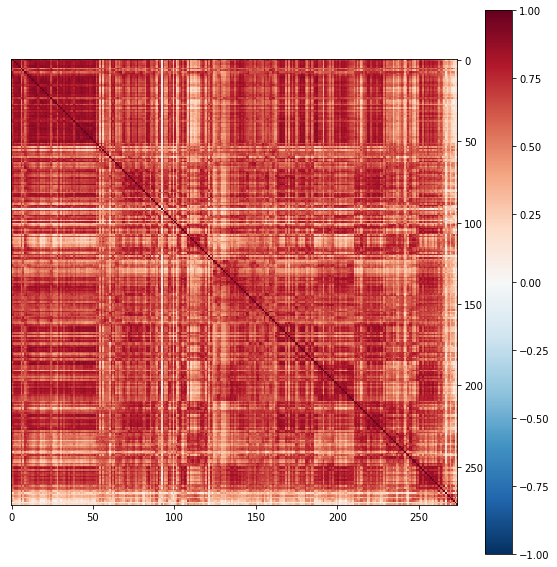

In [50]:
# Refrence: http://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html

from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# You can add a filtering function that keeps only high correalted values.

# Plot the correlation matrix
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
# Mask the main diagonal for visualization:
# np.fill_diagonal(correlation_matrix, 0)

plt.imshow(correlation_matrix, interpolation="nearest", cmap="RdBu_r",
           vmax=1.0, vmin=-1.0)

# Add labels and adjust margins
# x_ticks = plt.xticks(range(len(labels) - 1), labels[1:], rotation=90)
# y_ticks = plt.yticks(range(len(labels) - 1), labels[1:])
plt.gca().yaxis.tick_right()
plt.colorbar()
# plt.subplots_adjust(left=.01, bottom=.3, top=.99, right=.62)

## Observation:
I have not removed the confounds such as Motion Params, CSF signals.

Most of the brain is connected to most part.

Interesting thing to see would be to regress out confounds and then check the matrix.

Source: http://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py



# TODO:
1. Add a Map/Join Node to get a list of all the activations of subjects
    2. If Not that, then make a select files program to select the preprocessed func files
3. Read and Regress out the Motion regressors and CSF signals.
4. Create FC and check now.
5. Check if you can create a BIDS datasink or write a script for editing the data structure
5. Do group level analysis on the FC Maps on both of the data 

## Segmentation of Normalized functional Images' CSF 

In [54]:
# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Select WM segmentation file from segmentation output
# def get_wm(files):
#     return files[-1]

In [64]:
anat_filenames = opj(dataSink.inputs.base_directory,'preprocessed/sub-0050952/sub-0050952_T1w.nii.gz')
# segmentation.inputs.in_files = anat_filenames
anat_filenames

'/home/jovyan/work/preprocess/result/datasink/preprocessed/sub-0050952/sub-0050952_T1w.nii.gz'

In [67]:
os.chdir(dataSink.inputs.base_directory)
res = segmentation.run()

171004-12:08:30,373 workflow INFO:
	 Executing node segmentation in dir: /tmp/tmpJqEnRK/segmentation
171004-12:08:30,422 workflow INFO:
	 Running: fast -S 1 /tmp/tmpJqEnRK/segmentation/sub-0050952_T1w.nii.gz


In [74]:
lis = res.outputs.partial_volume_files

lis 
!fslinfo /tmp/tmpJqEnRK/segmentation/sub-0050952_T1w_pve_0.nii.gz

load_and_save(lis[0],'/home/jovyan/work/preprocess/result/pvf0.nii') # CSF File
load_and_save(lis[1],'/home/jovyan/work/preprocess/result/pvf1.nii') # Grey Matter
load_and_save(lis[2],'/home/jovyan/work/preprocess/result/pvf2.nii') # White Matter

data_type      FLOAT32
dim1           91
dim2           109
dim3           91
dim4           1
datatype       16
pixdim1        2.000000
pixdim2        2.000000
pixdim3        2.000000
pixdim4        1.000000
cal_max        0.0000
cal_min        0.0000
file_type      NIFTI-1+
Saving the brain file at:  /home/jovyan/work/preprocess/result/pvf0.nii
Saving the brain file at:  /home/jovyan/work/preprocess/result/pvf1.nii
Saving the brain file at:  /home/jovyan/work/preprocess/result/pvf2.nii


In [69]:
FAST.help()

Wraps command **fast**

Use FSL FAST for segmenting and bias correction.

For complete details, see the `FAST Documentation.
<http://www.fmrib.ox.ac.uk/fsl/fast4/index.html>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import example_data

Assign options through the ``inputs`` attribute:

>>> fastr = fsl.FAST()
>>> fastr.inputs.in_files = example_data('structural.nii')
>>> out = fastr.run() #doctest: +SKIP

Inputs::

	[Mandatory]
	in_files: (a list of items which are an existing file name)
		image, or multi-channel set of images, to be segmented
		flag: %s, position: -1

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	bias_iters: (1 <= an integer <= 10)
		number of main-loop iterations during bias-field removal
		flag: -I %d
	bias_lowpass: (4 <= an integer <= 40)
		bias field smoothing extent (FWHM) in mm
		flag: -l %d
	environ: (a dictionary with keys which are a newbytes or None or a
		 newstr or None and 

TODO:  Check the following link for removal of confounding variables:
http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.algorithms.confounds.html
http://fcp-indi.github.io/docs/user/nuisance.html

How to use GLM in nipype to regress out motion parameters?

This also look promising:
http://andysbrainblog.blogspot.in/2014/05/extracting-and-regressing-out-signal-in.html






## Utility Functions

In [51]:
# To load and save a brain image to a convenient location so that I can view it in fslview
import nibabel as nib

def load_and_save(filepath, name):
    brain_data = nib.load(filepath)
#     brain_tensor = brain_data.get_data()

    print "Saving the brain file at: ", name
    # brain_MC_with_header = nib.Nifti1Image(fullbrain_atlas, affine=bn.affine,header = bn.header)
    nib.save(brain_data, name)

In [52]:
# load_and_save(str(res.outputs.slice_time_corrected_file), 'slicetimecorrectedfile_50954)

In [53]:
# MCFLIRT.help()
# To Stop execution Raise error:
raise Exception('Execution stops here!')

Exception: Execution stops here!

# Supplementary Material

# One

>### Arguments for  extracting relevent files
Anatomical files:  
filename='..._T1w.nii.gz', type='T1w', modality='anat', subject='0050952'

>Functional files:  
filename='..._bold.nii.gz',type='bold', task='rest', run='1', modality='func', subject='0050952'

In [ ]:
# By typing 
layout.get()
# I get all the filenames with their parameters that I can use to extract the relevent files.


# Two
>## Constructing a workflow  
To make a workflow you need the input and output names of the Nodes.  
- > **Example workflow**:  
```wf.connect([(<Source_Node>, <Destination_Node>, [('<output_from_source_node>','<input_to_destination_node>')])```
- To get the name of input for a Node type ```<Node_Name>.inputs```  
- To get the name of output of a Node write ```<Node_Name>.outputs```

In [ ]:
# for example, to get the the input info of ExtractROI Node type:
extract.inputs

In [ ]:
# to get the the input info of ExtractROI Node type:
extract.outputs

In [ ]:
skullStrip.outputs

# Dump

In [ ]:
#Lets move ahead with creating more Nodes for preprocessing.  

#Extract ROI for skipping first 4 scans of the functional data 

# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

#Do motion correction. So as to ensure that for a subject each brain volume is 'insync' with the other volume.

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# To test mcflirt
mcflirt.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
res_mcflirt = mcflirt.run()
res_mcflirt.outputs

### To Visulize the output of mcflirt
1. Displayed in notebook only one volume using nilearn
2. Plotted histogram of original and corrected files
3. Saved copies of original and corrected files using nibabel to see in fslview

from nilearn import image

brain = image.load_img('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')
brain_MC = image.load_img('/tmp/tmpZG2rZL/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii')


tenth_brain = image.index_img(brain, 30)
tenth_brain_MC = image.index_img(brain_MC, 30)


%pylab inline
from nilearn.plotting import plot_anat
plot_anat(tenth_brain, title='Original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)


from nilearn.plotting import plot_anat
plot_anat(tenth_brain_MC, title='Motion Corrected',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

#The output as well as input looked washed out. So checked the intensity values of the brain

import numpy as np
import nibabel as nib

brain_original = nib.load('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')
brain_MC = nib.load('/tmp/tmpZG2rZL/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii')

# checked max and min values of original brain
np.max(brain_original.get_data()),np.min(brain_original.get_data())

# checked max and min values of corrected brain
np.max(brain_MC.get_data()),np.min(brain_MC.get_data())

# checked how many unique floor(values) does the brain has
(np.unique(np.floor(brain_MC.get_data())))

# Plotted the histogram

import matplotlib.pyplot as plt
brain_original_flattened = (brain_original.get_data()).flatten()
brain_MC_flattened = (brain_MC.get_data()).flatten()

plt.hist(brain_flattened)



plt.hist(brain_MC_flattened)

# Save the motion corrected brain to analyze if it is correct

print "Saving the Motion corrected brain "
# brain_MC_with_header = nib.Nifti1Image(fullbrain_atlas, affine=bn.affine,header = bn.header)
nib.save(brain_MC, 'motion_corrected_50594')

## Observation:

After seeing it in fslview, I conclude that the overall conrast has been reduced and brain image has become dull as seen in the histogram. I don't know if this is correct or not but this is th output that I got by applying MCFLIRT on the given fmri data for subject 50594

### Do slice time correction  
> **Arguments**:  
index_dir=False -> Slices were taken bottom to top i.e. in ascending order  
interleaved=True means odd slices were acquired first and then even slices [or vice versa(Not sure)] 

In [ ]:
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

slicetimer.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
res = slicetimer.run();

In [ ]:
mcflirt.outputs

skullStrip.inputs

skullStrip.outputs

In [ ]:
# Testing applying mask on functional data 

# def applyMask_func(brain_file, mask_file):
import numpy as np
import nibabel as nib
import os

brain_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
mean_file = '/tmp/tmpVHzuw1/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii_mean_reg.nii'

skullStrip.inputs.in_file = mean_file
res = skullStrip.run()

mask_file = str(res.outputs.mask_file)

brain_data = nib.load(brain_file)
mask_data = nib.load(mask_file)

brain = brain_data.get_data()
mask = mask_data.get_data()

for t in range(brain.shape[-1]):
    brain[:,:,:,t] = np.multiply(brain[:,:,:,t],mask)

# Saving the brain file

func_brain_path = mask_file + '_func_brain.nii.gz'

brain_with_header = nib.Nifti1Image(brain, affine=brain_data.affine,header = brain_data.header)
nib.save(brain_with_header,func_brain_path)

# save at the local PWD to see using fsl
load_and_save(func_brain_path,'skul_stripped_50954')


In [ ]:
str(res.outputs.slice_time_corrected_file)

In [ ]:
from nipype.interfaces.afni import Resample

### Co-Registration and Normalization [Link](https://en.wikibooks.org/wiki/Neuroimaging_Data_Processing/Coregistration_and_Normalization#Concept_of_Coregistration)
1. Register the mean EPI image to Highres Anatomical image
2. Register the Highres Anatomical image to Standard space
3. Use the Transformation Matrix got in (2.) to register the EPI images to standard space.




Register the mean EPI image to Highres Anatomical image

In [ ]:
# FLIRT - coregister functional images to anatomical images
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")

coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")

coreg_step1_Normalize = Node(FLIRT(reference='/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz',
                         output_type='NIFTI'), name="coreg_step1_Normalize")

coreg_step2_Normalize = Node(FLIRT(reference='/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz',
                         output_type='NIFTI', apply_xfm=True), name="coreg_step2_Normalize")


In [ ]:

# wf.connect([(mcflirt,skullStrip,[('mean_img','in_file')]),
#             (BIDSDataGrabber,skullStrip,[('anat_file_path','in_file')]),
#             (skullStrip,coreg_step1,[('out_file','reference')]),
#             (skullStrip,coreg_step1,[('mask_file','reference')]),
#             (skullStrip,coreg_step2,[('out_file','in_file')])
#            ])

### Add this to the main workflow. (First 2)It Registers the functional image to anatomical image

template = Info.standard_image('MNI152_T1_2mm_brain.nii.gz') # path of the MNI tempelate in unicode
```
wf.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]),
            (BIDSDataGrabber,coreg_step1,[('anat_file_path','reference')]), # Mean functional and anatomical file given as input to coreg_step to register mean functional to anatomical scan
            
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), 
            (BIDSDataGrabber,coreg_step2,[('anat_file_path','reference')]),
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),  # Sending the transformation matrix, refrence file, and the input file. Input file is transformed using the transformation matrix     
            
            (BIDSDataGrabber, skullStrip, [('anat_file_path','in_file')]), # Skull stripping the anat file,
            (skullStrip, applyMask, [('mask_file','mask_file')]),
            (coreg_step2,applyMask, [('out_file','brain_file')], # generating mask and applying it to functional data of subject
            
            #-------- Now register the anatomical brain (skullStrip's out fie) to the MNI brain
             
            (skullStrip, coreg_step1, [('out_file','in_file')])
            
             ])
            
```



-- need to code for rest 2 to get the xform matrix from anat to mni
-- apply xform to all the functional images


In [ ]:
wf_coreg = Workflow(name="coregistrationPipeline")
wf_coreg.base_dir = "/home/jovyan/work/preprocess/result_coreg" # Dir where all the outputs will be stored(inside BETFlow folder).


wf_coreg.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]),
            (BIDSDataGrabber,coreg_step1,[('anat_file_path','reference')]),
            
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), 
            (BIDSDataGrabber,coreg_step2,[('anat_file_path','reference')]),
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),
            
            (BIDSDataGrabber, skullStrip, [('anat_file_path','in_file')]),
            (skullStrip, applyMask, [('mask_file','mask_file')]),
            (coreg_step2, applyMask, [('out_file','brain_file')]),
             
            (skullStrip, coreg_step1_Normalize, [('out_file','in_file')]), # gives the transformation matrix
            
            (applyMask, coreg_step2_Normalize, [('out_file','in_file')] ) # Applies the transform to the functional file       
                  
           ])

In [ ]:
# Visualize the detailed graph
from IPython.display import Image
wf_coreg.write_graph(graph2use='exec', format='png', simple_form=True)

Image(filename='/home/jovyan/work/preprocess/result/coregistrationPipeline/graph_detailed.dot.png')

In [ ]:
# Normalization using ANTS
from nipype.interfaces.ants import ApplyTransforms

from nipype.interfaces.fsl import Info
# Template to normalize to
template = Info.standard_image('MNI152_T1_2mm_brain.nii.gz') # path of the MNI tempelate in unicode



In [ ]:
%%bash
fslstats /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz -v

fslstats ../data/ABIDE-BIDS/NYU/sub-0050954/anat/sub-0050954_T1w.nii.gz -v

#fslinfo /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz
fslview /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz

I came to know from someone that for FLIRT to work fine, the volume of refrence and input file must be same. That is,  

>`n1 x voxel_volume = n1 x voxel_volume`  

n1 : Number of volxels in brain 1
n2 : Number of volxels in brain 2

Voxel volume = mm x mm x mm

fslstats told me that brain volumes are not same. Lets see how the registration goes. 

In [ ]:
template

In [ ]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = Node(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='Linear',
                                    invert_transform_flags=[False],
                                    num_threads=8,
                                    reference_image=template,
                                    terminal_output='file'),
                                name='apply2con')

In [ ]:
FLIRT.help()

In [ ]:
coreg_step2.outputs


In [ ]:
skullStrip.outputs

In [ ]:
FLIRT.help()

In [ ]:
FLIRT

In [ ]:
applyMask.inputs.in_file

In [ ]:
applyMask.outputs

In [ ]:
# Old workflow:
# Create the workflow
# Refer to Supplementary material's Section Two for more on workspaces

wf = Workflow(name="preprocessPipeline")
wf.base_dir = "/home/jovyan/work/preprocess/result" # Dir where all the outputs will be stored(inside BETFlow folder).

wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,mcflirt,[('slice_time_corrected_file','in_file')]),
                  (mcflirt, skullStrip, [('mean_img', 'in_file')]),
                  (mcflirt,applyMask,[('out_file','in_file')]),
                  (skullStrip, applyMask, [('mask_file', 'mask_file')]), 
                  ])
# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 8})

In [ ]:
# Spending too much time in:
#flirt -in /home/jovyan/work/preprocess/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/mcflirt/sub-0050952_task-rest_run-1_bold_roi_st_mcf.nii -ref /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/anat/sub-0050952_T1w.nii.gz -out sub-0050952_task-rest_run-1_bold_roi_st_mcf_flirt.nii -omat sub-0050952_task-rest_run-1_bold_roi_st_mcf_flirt.mat -applyxfm -init /home/jovyan/work/preprocess/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/coreg_step1/sub-0050952_task-rest_run-1_bold_roi_st_mcf.nii_mean_reg_flirt.mat

# cmdline: 
# flirt -in bold_roi_st_mcf.nii
#       -ref T1w.nii.gz 
#       -out bold_roi_st_mcf_flirt.nii
#       -omat bold_roi_st_mcf_flirt.mat 
#       -applyxfm 
#       -init bold_roi_st_mcf.nii_mean_reg_flirt.mat



In [ ]:
MCFLIRT.help()

In [ ]:
!flirt

In [ ]:
MCFLIRT.help()

### IdentityInterface node to Distribute the subjects 
I realized that it is **not Needed**. Making BIDSDataGrabber as an itereble node also works prefectly fine.

Create a list of subjects

In [ ]:
subject_list = (layout.get_subjects())[0:number_of_subjects]

Create an IdentityInterface Node that helps us to iterate over all the subjects. In this type of node the inputs = outputs that's why its called an identity node. It has an aditional feature that it can iterate over the values a single field can take. In our case we tell it to iterate over field '`subject_id`' and take values given by `subject_list`

In [ ]:
from nipype import IdentityInterface


infosource = Node(IdentityInterface(fields=['subject_id','data_dir']),
                  name="infosource")
infosource.inputs.data_dir = data_directory 
infosource.iterables = [('subject_id', subject_list)]
# Note: Field 'data_dir' stays constant while the field'subject_id' takes on various values 
#       as there are multiple subjects

infosource.inputs #Checking the inputs of the above created node

infosource.outputs # Checking the outputs of the above created node

## Band Pass Filtering
Let's do a band pass filtering on the data using the code from http://nipype.readthedocs.io/en/latest/users/examples/rsfmri_vol_surface_preprocessing_nipy.html

In [ ]:
def bandpass_filter(files, lowpass_freq, highpass_freq, fs):
    import numpy as np
    import nibabel as nb
    import os
#     from nipype.utils.config import NUMPY_MMAP
    from nipype.utils.filemanip import (filename_to_list, split_filename,
                                        list_to_filename)
    """Bandpass filter the input files

    Parameters
    ----------
    files: list of 4d nifti files
    lowpass_freq: cutoff frequency for the low pass filter (in Hz)
    highpass_freq: cutoff frequency for the high pass filter (in Hz)
    fs: sampling rate (in Hz)
    """
    base_directory = '/home/jovyan/work/preprocess/result'
    
    out_files = []
    for filename in filename_to_list(files):
        path, name, ext = split_filename(filename)
#         out_file = os.path.join(os.getcwd(), name + '_bp' + ext)
        out_file = os.path.join(base_directory, name + '_bp' + ext)
        br_img = nb.load(filename)#, mmap=NUMPY_MMAP)
        img = br_img.get_data()
        timepoints = img.shape[-1]
        F = np.zeros((timepoints))
        lowidx = int(timepoints / 2) + 1
        if lowpass_freq > 0:
            lowidx = np.round(float(lowpass_freq) / fs * timepoints)
        highidx = 0
        if highpass_freq > 0:
            highidx = np.round(float(highpass_freq) / fs * timepoints)
        F[highidx:lowidx] = 1
        F = ((F + F[::-1]) > 0).astype(int)
        data = br_img.get_data()
        if np.all(F == 1):
            filtered_data = data
        else:
            filtered_data = np.real(np.fft.ifftn(np.fft.fftn(data) * F))
        img_out = nb.Nifti1Image(filtered_data, br_img.affine, br_img.header)
        img_out.to_filename(out_file)
        out_files.append(out_file)
    return list_to_filename(out_files)

### Let's Create a Node of the above function and try to execute it.

In [ ]:
bandpassFilter = Node(Function(function=bandpass_filter, input_names=['files','lowpass_freq','highpass_freq','fs'],
                                output_names=['filtered_func']), name='bandpassFilter')

In [ ]:
subject_id = layout.get_subjects()[0]

In [ ]:
func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])] 
bandpassFilter.inputs.files = func_file_path
bandpassFilter.inputs.lowpass_freq = 0.08
bandpassFilter.inputs.highpass_freq = 0.001  # Source:https://wiki.biac.duke.edu/biac:analysis:resting_pipeline
bandpassFilter.inputs.fs = 1/TR

In [ ]:
# Testing some Nipype utility functions;
from nipype.utils.filemanip import (filename_to_list, split_filename,
                                        list_to_filename)

func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])] 
filename_to_list(func_file_path[0])

In [ ]:
import nibabel as nib
_img = nib.load('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz')

files = filename_to_list(func_file_path)
for filename in filename_to_list(files):
    print type(filename)

In [ ]:
# res = bandpassFilter.run()



## I could not run the Nipype Band pass filter code, So I am resorting to AFNI's band pass function. 

In [ ]:
# FLIRT.help()

In [ ]:
# Connecting IdentityInterface to the workflow to read the data
# (infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),

TODO - > Write documentation of observation of datasink
- what all folders were created and how
- read the output names and rename using substitutions.

Check if I can use the same node twice or not

In [ ]:
MNI152_2mm = Node(IdentityInterface(fields=['standard_file','mask_file']),
                  name="MNI152_2mm")
# Set the mask_file and standard_file input in the Node. This setting sets the input mask_file permanently.
MNI152_2mm.inputs.mask_file = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
MNI152_2mm.inputs.standard_file = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz'



wf_coreg_edit = Workflow(name="coregistrationPipeline_edit")
wf_coreg_edit.base_dir = "/home/jovyan/work/preprocess/result" 
# Dir where all the outputs will be stored(inside coregistrationPipeline folder).


wf_coreg_edit.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]), # Sent the mean volume from mcflirt to coreg_step1
                  
            (BIDSDataGrabber,resample,[('anat_file_path','in_file')]), # Resampled the anat file to 2mm
                  
            (resample,coreg_step1,[('out_file','reference')]), # Make the resampled file as reference in coreg_step1
            
            # Sec 1. The above 3 steps registers the mean image to resampled anat image and 
            # calculates the xformation matrix       
                  
                  
                  
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), # Motion corrected volumes (wrt mean-volume) given ...
            # ...as input to coreg_step2
                  
            (resample,coreg_step2,[('out_file','reference')]), # Resampled 2mm anat used as reference to coreg_step2
                  
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),# xformation matrix (mean->anat) ...
            # ... is used to transform func volumes to resampled anat
            
            # Sec 2. The above 3 steps uses the xformation matrix computed in Sec 1. and
            # trasforms the func volumes to resampled anat.        
          
                  
                                  
            (resample, skullStrip, [('out_file','in_file')]), # resampled anat image is skull stripped and mask ...
            # ... is generated
                  
            (skullStrip, applyMask, [('mask_file','mask_file')]), # the mask is inputted in applyMask
                  
            (coreg_step2, applyMask, [('out_file','in_file')]), # The functional image is inputted in applyMask
                  
            # Sec. 3. The above 3 Steps result is the skull stripping of func data based on mask got from anat
                  
                  
            (MNI152_2mm, coreg_step1,[('standard_file','reference')]) ,     
            (skullStrip, coreg_step1, [('out_file','in_file')]), # above 2 steps gives the transformation matrix ...
            #... anat->MNI_2mm
            
#             (coreg_step1, coreg_step1_Normalize_masking, [('out_file','in_file')]), # masking again the ...
#             # ... Normalized anat image
                  
#             (MNI152_2mm_mask, coreg_step1_Normalize_masking, [('mask_file','mask_file')]), # using the mask from ...
#             # ... MNI152_2mm_mask 
            
            # Sec 4. Above 3 steps masks again the normalized anat and the next statement saves it to dataSink
                  
                  
            
            # Saving the normalized anatomical file of a subject
            (coreg_step1,dataSink,[('out_file','preprocessed.@normalized_anat')]),
                  
#------------------------------------------------------------------------------------------------------------------                 
#             # TODO: Now register the functional mean image to the above got normalized anat using coreg_step1
#                   # - Need to first create a xformation matrix with:
#                   #     - Reference as normalized anat got from - coreg_step1_Normalize_masking
#                   #     - in_file = func volume got from - applyMask
#                   #     - 
#             (coreg_step1_Normalize_masking, coreg_step1, [('out_file','reference')]),
#             (mcflirt->skullStrip, coreg_step1, [('out_file','in_file')]),    
#-------------------------------------------------------------------------------------------------------------------  
                  
                  
            (MNI152_2mm, coreg_step2,[('standard_file','reference')]) ,      
            # Now, apply the matrix got using coreg_step1 to the functional                       
            (applyMask, coreg_step2, [('out_file','in_file')] ), # Applies the transform to the ...
            # ... functional file       
            
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),
                  
            (coreg_step2, dataSink, [('out_file','preprocessed.@normalized_func')]) # saving the normalized ...
            # ... functional file of a subject     
           
            # Sec 5. The above steps transforms the functional to the MNI space using the xformation matrix (resampled_anat -> MNI)      
            
            ])


### NOTE: Looking at the above output I can conclude that the same node cannot be reused again.

But! you can clone the node using node.clone('name')